# Quantitative Finance with Python

### Alan Moreira, University of Rochester Simon Graduate School of Business

# Notebook 5




### Topics covered
* * *
 * Portfolio optimization with constraints
 * Estimation uncertainty
 * Statistical tests
 * Minimum-Variance investing
 * Risk-parity investing
 * Portfolio choice using equilibirum thinking

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#GlobalFinMonthly
url="https://www.dropbox.com/s/3k35mt3t57ygff2/GlobalFinMonthly.csv?dl=1"
Data = pd.read_csv(url,na_values=-99)
# tell python Date is date:
Data['Date']=pd.to_datetime(Data['Date'])
# set an an index
Data=Data.set_index(['Date'])
print(Data)
Data=Data.rename(columns={Data.columns[1]: "MKTUS",Data.columns[2]: "BondUS",
                          Data.columns[3]: "EM",Data.columns[4]: "MKTxUS",Data.columns[5]: "BondxUS" })
print(Data)
Re=(Data.drop('RF',axis=1)).subtract(Data['RF'],axis='index')
Re.tail()

# Portfolio optimization in practice

* Investment managers rarely apply the Mean-Variance framework in it's more pure form as studied in Notebook 4

* Pension funds often use an 60/40 equity/bond allocation 

* Why not used more often? 

* Requires specifying expected return assumption for entire universe of assets

* Mean-variance optimization weights heavily on assets that have extreme average returns and with attractive covariance properties, i.e., high correlation with asset yielding slightly different return

* What problems that might cause?

* The key problem is that we are dealing with a limited sample of data

* We are interested in finding the ex-ante tangency portfolio

* But MV analysis identifies the ex-post tangency portfolio, i.e., a portfolio that did well in the sample, but it can be a statistical fluke

> How to evaluate the amount of uncertainty and it’s impact in our results?

* Another practical issue that practiciners face is that MV analysis (in it's more pure form) does not account for several real world frictions that are more or less important depending of the investor:

 * Shorting an asset requires paying a borrowing fee to the owner of the asset. Shorting costs are sometimes prohibitive for small illiquid stocks
 
 * Most investors cannot really borrow at anything close to the risk-free rate--i.e., often the have to pay a substantial higher rate to borrow then to lend. 
 
 > Between two assets, one with high beta with respect to the tangency portfolio and one with low beta, which  one this constrained investor prefers?
 
 




# Portfolio constraints

* Python has the flexibility to solve the mean-variance problem numerically

* allow you to impose realistic features to our portfolio problem 

  * Shorting costs
  * Borrowing cost higher than lending costs
  * Leverage constraints
  * Position limits due to investment mandates
  


In [2]:
# start by importing optimization package -- think of a much more powerful solver (excel)

from scipy.optimize import minimize

* we will now learn how to learn how to do a numerical minimization. 

* first start by defining some useful variables

In [3]:
Re.tail()

,MKTUS,BondUS,EM,MKTxUS,BondxUS
Date,,,,,
2016-08-31,0.0050,-0.008617,0.024986,0.000638,-0.009752
2016-09-30,0.0025,-0.016617,0.012953,0.012536,0.009779
2016-10-31,-0.0202,-0.049660,0.002274,-0.020583,-0.043676
2016-11-30,0.0486,-0.081736,-0.046071,-0.019898,-0.050459
2016-12-31,0.0182,-0.005596,0.002604,0.034083,-0.023507


In [4]:
# excess returns
Re=Data.subtract(Data['RF'],axis='index').drop('RF',axis=1)

ERe=Re.mean()

Cove=Re.cov()
# the risk-free rate is special because at a given time we know exactly what are the expected returns of investing
# in it, since it is risk-free!
# so it does not make sense to use the average risk-free rate in the portfolio problem, and we should rather the one 
# we currently can invest at no risk
# here we are dividing by 12 becasue we are entering annualized numbers
rf=0.0192/12

# this above is the target for monthly expected returns
Ertarget=0.12/12


# here is maximum amount of borrowing at the risk-free rate. 1.5 means that for each dollars you put in you can borrow 
# up to 50 cents and have a total risk asset portfolio of 1.5 dollars
levlimit=0

* The program will choose a vector of weights that minimizes some function (of the chosen weights) subject to some constraint.

* we now need to provide an initial condition for these weights, which essentially tell python what is the shape of variable that it is choosing. Here we will initiate the algorithm a equal weighted portfolio.

* When solving minimization problems it is important to check that the initial condition does not matter.

* I mean, it's shape obviously matter-- if you put the wrong shape it will freeze imemdiately!-- but whether is equal weighted or any other weighting scheme, the minimization should end up in the same place otherwise the numerical  is not converging and you need to adjust the stop conditions.



* We refer to this as making sure that you are finding a "global optimum" and not a "local optimum"

* Of course, it might be that for some initial conditions the algorithm gets stuck somewhere ("local optimum")

In [5]:
n=Re.shape[1]
W0=np.ones(n)/n 

W0

array([0.2, 0.2, 0.2, 0.2, 0.2])

* We need to specificy the function that our minimizer will try to minimize,i.e, our objective

* obviously this should be written as a function of the portfolio weights

* In this case it is the variance of a portfolio with weights W

* the weights will be our choice variable

* The minimization function will change the weights until this variance is minimized


In [6]:


def func(W):
    return W.T @ Cove @ W


* Finally we need to specify the set of constraints that the minimization problem must satisfy

* you can specify two types of constraints: Equalities and inequalities.

* Equalities:
   * specified as 'eq' 
   * For example:{'eq', 'fun' : lambda W : W.T @ ERe.values+rf-target}
     * defines the function F(W)=W.T @ ERe.values+rf-target
     * and requires W to satisfy F(W)=0, i.e.,W.T @ ERe.values+rf=target
     * "target" here is the target for expected returns
     
* Inequalities:
   * specified as 'ineq'
   * For example: {'ineq', 'fun' : lambda W: -W.sum()+1+ levlimit}
   * Defines  F(W)=-W.sum()+1+levlimit
   * and requires F(W)>=0, i.e.,
   
   $$levlimit\geq W.sum()$$

In [7]:
Ertarget=0.08/12

cons=({'type': 'eq',
          'fun' : lambda W : W.T @ ERe.values+rf-Ertarget},
        {'type': 'ineq',
          'fun' : lambda W: -W.sum()+levlimit+1},
        {'type': 'ineq',
          'fun' : lambda W: W}) 





* Finally we are ready to so do our minimization
* options={'disp': True}: tell python to report intermediary steps so we can check if the algorithm is doing progress towards a solution.
* There is a variety of additional parameters that you can pass to the minimizer. 
* see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html


In [16]:
sol = minimize(func,W0, constraints=cons, options={'disp': True})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005153285027626039
            Iterations: 11
            Function evaluations: 77
            Gradient evaluations: 11


* Solution is saved in sol
* Lets plot the optimal weights

In [18]:
sol.fun**0.5


0.0717863846953309

[Text(0,0,'MKTUS'),
 Text(0,0,'BondUS'),
 Text(0,0,'EM'),
 Text(0,0,'MKTxUS'),
 Text(0,0,'BondxUS')]

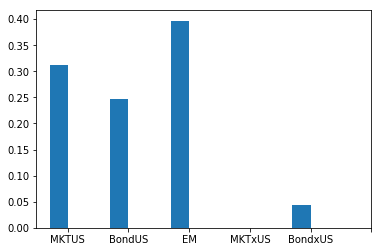

In [10]:

# below I am plotting the solution weights.
width=0.3
ind=np.arange(Re.shape[1])
fig, ax = plt.subplots()
ax.bar(ind,sol.x,width)

ax.set_xticks(np.array([0,1,2,3,4,5])+ width / 2)
ax.set_xticklabels(Re.columns)

* We can now use a for loop to trace out the entire mean-variance frontier when neither borrowing or lending at the risk-free rate is allowed

* we do this by minimizing the variancewith different targets for expected returns

In [11]:
# here we constructing a list of target ranging from the risk-free rate until 12%, 
# with 40 equally distanced points in between
levlimit=0
mutargets=np.linspace(rf,0.12/12,100)

# We are initiating a list where we will be storing the results
minstd=[]

# we now simply loop over the different expected return targets in the vector which we just constructed



for a0 in mutargets:
    #   1. The loop fisrt define the new constrain with the new expected return targe given by a0
    cons=({'type': 'eq',
          'fun' : lambda W : W.T @ ERe.values+rf-a0},
        {'type': 'ineq',
          'fun' : lambda W: -W.sum()+1+levlimit} ,
        {'type': 'ineq',
          'fun' : lambda W: W[[0,4]]})
    #   2. It then performs the minimization
    res1 = minimize(func,W0,  constraints=cons, options={'disp': False})
    #   3. Finally it appends the solution to the list that we just created. 
    #        Here we are saving the square of the objective function, which is simply the standard deviaiton 
    #        of the optimal portfolio. And the also the expected return obtained (alternatively we could have simply saved a0)
    minstd.append([res1.fun**0.5,res1.x @ ERe.values+rf])


* We can now plot the mean-standard-deviation fornties by plotting the obtained stnandard deviaiton in the x-axis and the obtained expected returns in the y-axis


In [12]:
W0=np.arange(5)
W0[[0,4]]

array([0, 4])

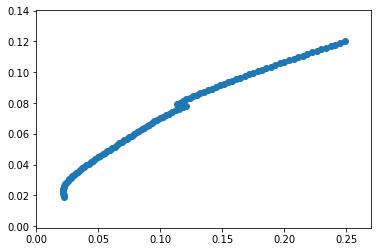

In [13]:
plt.scatter(np.array(minstd)[:,0]*12**0.5,np.array(minstd)[:,1]*12)

* You can do a multitude of different problems by making small changes to this code:

    * Borrowing at the risk-free rate is not allowed,  but lending is allowed
    * Shorting of any asset is not allowed
    * Shorting of some assets are not allowed
    * Shorting has an extra cost
    * leverage is allowed, but borrowing rate is higher than risk-free rate
    
 > How would you implement no shorting of any asset?
 
 > How would you implement no shorting of bonds, but allow investor to short equity markets (which can be done using futures)?
 


     
# Estimation uncertainty     

* We will start by evaluating the uncertainty regading our average expected excess return estimates for each asset

* We will then show how the weights change as we pertubate these estimates in a way that is consistent with the amount of uncertainty

* We will then show how sensitive the benefits of international diversification are

* If observation are serially uncorrelated over time, which returns on liquid assets are close to being, than the standard deviation of a sample average is simply

$$std\left(\sum_i^N\frac{x_i}{N}\right)=\frac{std(x_i)}{\sqrt{N}}$$


* This measures how uncertain we are about the sample mean

* For example, there is a 5% probability that the actual mean is $E[x_i]\leq\overline{x_i}-1.64{std(\overline{x_i})}$

* So $std(\overline{x_i})$ gives a measure of how close our estimate is to the true expected value

* Let compare the sample average and the sample average standard deviation for our assets

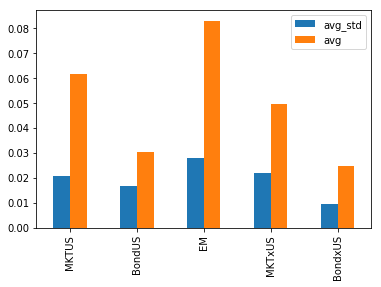

In [20]:
# Lets contrast the WMVE weights with the SR of each 
avg_std=(Re.std()/(Re.shape[0]**0.5))*12
avg=Re.mean()*12
ERstd=pd.concat([avg_std,avg],axis=1)
ERstd=ERstd.rename(columns={1:'avg',0:'avg_std'})
ERstd.plot.bar()

* Note that our data set has  50 years of data, there is still considerable uncertainty, specially for bonds

In [21]:
#number of years
Re.shape[0]/12

53.916666666666664

# Statistical tests

* T-stat for a given hypothesis $\mu_{j}^0$

$$t_j(\mu_0)=\frac{\bar{R_j}-\mu_{j}^0}{\sigma(\bar{R_j})}$$

* For example lets assume we have strong theoretical reasons to believe that these assets must not have a negative expected returns. (True for the value-weighted stock market, less true for bonds)

* So lets do a 1-sided test with 5% interval and ask what it is the largest expected return $X_j$ that we can say with 95% confidence that the asset j has expected return higher than $X_j$

$$1.64=\frac{\bar{R_j}-\mu_{j}^0}{\sigma(\bar{R_j})}$$

* If we are evaluating the hypothesis that $\mu_{j}=0$, we say that 

  * if $\frac{\bar{R_j}-0}{\sigma(\bar{R_j})}\geq 1.64$, we can statistically reject that $\mu_{j}=0$ with a 95% confidence (or alternatively: we can statistically reject that $\mu_{j}=0$ with a 5% probabilit value (pvalue) )
  * if $\frac{\bar{R_j}-0}{\sigma(\bar{R_j})}<1.64$, we fail to statistically reject that $\mu_{j}=0$ with a 95% confidence (or alternatively: we fail to statistically reject that $\mu_{j}=0$ with a 5% probabilit value (pvalue) )
  

* Equivalently we can also construct our confidence intervals for the expected mean

$$\mu_{j}^{-,95\%}=\bar{R_j}-1.64\sigma(\bar{R_j})$$

$$\mu_{j}^{+,95\%}=\bar{R_j}+1.64\sigma(\bar{R_j})$$


* We say that this interval $[\mu_{j}^{-,95\%}, \mu_{j}^{+,95\%}]$ contains the true expected value with 95% probability

Here is a look at t-stats relative to a zero null-hypothesis (which is what people often do)

> Side comment: Why am using 1.64?

Recall from Notebook 3:

In [25]:
from scipy.stats import norm
ps=norm(0,1)
ps.isf(0.05/2)

1.9599639845400545

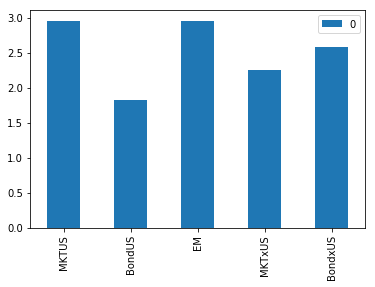

In [24]:
# we can look at the t-stats (against zero) for the assets
# the average return divided by the average return estiamtor standard deviation
ERstd=pd.concat([Re.mean()/(Re.std()/(Re.shape[0]**0.5))],axis=1)
ERstd.plot.bar()

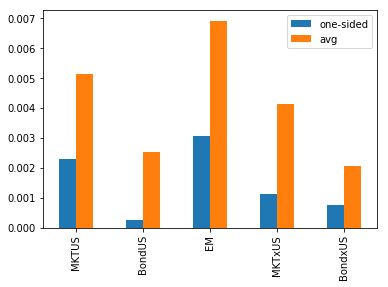

In [26]:
ER0=pd.concat([Re.mean()-1.64*(Re.std()/(Re.shape[0]**0.5)),Re.mean()],axis=1)
ER0=ER0.rename(columns={1:'avg',0:'one-sided'})
ER0.plot.bar()

### Two-sided intervals

* if we are more agnostic and believe less in the economic theories we have,

* Or the theories are silent

* For example, the theories are silent n long-short portfolios of equities, for example, the portfolio that goes long the US market and sells the international market.

* Then we must do a two-sided interval

> What is the 95% threshold for a two sided test?

In [28]:
ps.isf(0.05/2)

1.9599639845400545

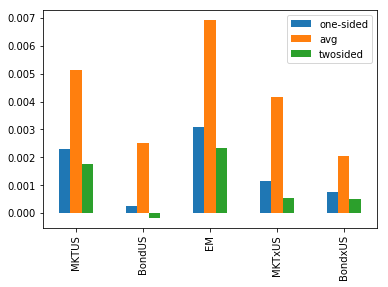

In [29]:


ER0['twosided']=Re.mean()-1.96*(Re.std()/(Re.shape[0]**0.5))

ER0.plot.bar()

### Pvalues


* Instread of use our t-stats to do a test at particular level of significance , say 95%

* We can use the normal cdf to find p-values, which give us that he highest level of significance our data is consistent with

* Here again, agaist the zero null hypothesis

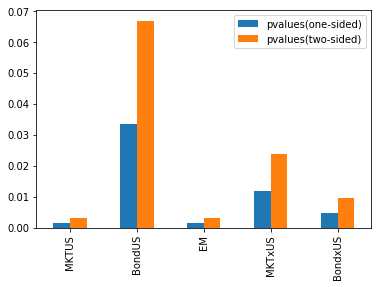

In [30]:



ER0['pvalues(one-sided)']=1-ps.cdf((Re.mean()/(Re.std()/(Re.shape[0]**0.5))).values)
ER0['pvalues(two-sided)']=(1-ps.cdf(np.abs((Re.mean()/(Re.std()/(Re.shape[0]**0.5))).values)))*2
ER0[['pvalues(one-sided)','pvalues(two-sided)']].plot.bar()

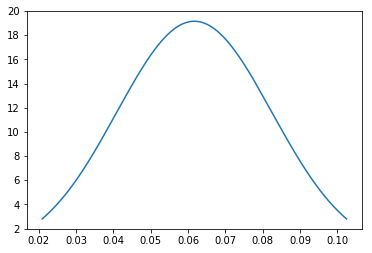

In [31]:
# lets look at 95% confidence interval (I am annulaizing for convenience)
interval=0.95
tails=(1-interval)/2

asset='MKTUS'
mu=Re[asset].mean()*12
mu_sigma=Re[asset].std()*(12)/Re[asset].count()**0.5
p=norm(mu,mu_sigma)

lefttail=p.isf(tails)
righttail=p.isf(1-tails)
# or equivalently
#lefttail=mu+pnorm.isf(tails)*musigma
#righttail=mu+pnorm.isf(1-tails)*musigma

# this constructs a grid going spanning the region given by the confidence interval
grid=np.linspace(lefttail,righttail,1000)
# note that x=pnorm.isf(q) is the inverse of the CDF.

#The inverse CDF at q is also referred to as the q quantile of a distribution.
#For a continuous distribution dist the inverse CDF at q is the value x such that CDF[DIST,x]=q. 
# So there is excatly probability q that the realization is higher than x.
plt.plot(grid, p.pdf(grid))
plt.show()

* a more relevant test is whether all these assets have the same average return

> Why that is the most relevant hypothesis for us as we do MV optimization?

* For assets that have a average return below the average, I compute the probability that this expected return is indeed below, and  for assets that have the avg return above avg I compute the probbility that the expected return is indeed  above the mean across assets

* I will simply use the absolute value to do that

In [33]:
Re.mean().mean()

0.004157534936321483

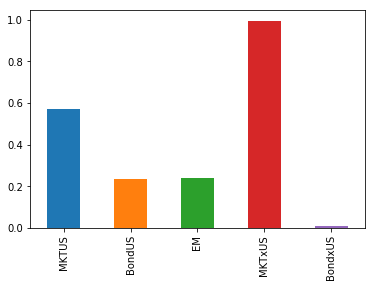

In [34]:

# or much more easily:
stdmean=Re.std()/(Re.shape[0]**0.5)
ER0['same_avg_pvalue']=(1-ps.cdf(np.abs((Re.mean()-Re.mean().mean())/stdmean).values))*2

# pvalue is the probability that the null hupothesis is right. So in this case it tells us that there is 
#a 60% probability that the mktus return equals to the average  and 100% probability that the MKTxUS expected return
# is equal to the average of all assets average returns


ER0.same_avg_pvalue.plot.bar()

> Can you interepret this plot?

In [40]:
# mve for sample mean
Wmve=pd.DataFrame([],index=Re.columns)
Wmve['samplemean'] =np.linalg.inv(Cove) @ ERe.values
Wmve

,samplemean
MKTUS,1.834995
BondUS,1.423872
EM,1.605498
MKTxUS,-1.026051
BondxUS,3.368940


In [42]:
# lets look at what happens with weights and Sharpes as we pertubate the mean of the market return by one standard deviation



Ere=Re.mean()
T=Re.shape[0]
# lets perturb the market mean using the 1 sided 95% confidence

ERemsig=Ere.copy()
asset='MKTUS'
pertubation=1.64
mu=Re[asset].mean()
musigma=Re[asset].std()/T**0.5
ERemsig[asset]=mu-pertubation*musigma

# mve for perturbed mean
Wmve[asset+'-'+str(pertubation)+'std'] =np.linalg.inv(Cove) @ ERemsig.values



# why I am using absolute values to normalize the weights?
Wmve=Wmve/Wmve.sum().abs()
Wmve


,samplemean,MKTUS-1std,MKTUS-1.64std
MKTUS,0.254604,0.045314,-0.112806
BondUS,0.197561,0.261140,0.309174
EM,0.222761,0.281097,0.325170
MKTxUS,-0.142364,-0.033959,0.047942
BondxUS,0.467437,0.446408,0.430520


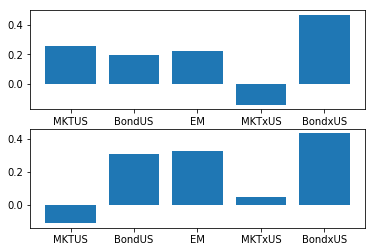

In [43]:
# lets compare with the MVE weights using the sample mean
plt.subplot(2,1,1)
plt.bar(x=ERe.index,height=Wmve['samplemean'])
plt.subplot(2,1,2)
plt.bar(x=ERe.index,height=Wmve['MKTUS-1.64std']/np.abs(Wmve['MKTUS-1.64std'].sum()))
plt.show()

# observation: In class I got all confused with this plot. Basically, I was dividing by the sum of the weights to normalize 
# the weights so we could clearly see in the plot (again, only relative weights matters becasue we are looking as excess returns)
# but obviously I cannot multiply/divide by a negative number otherwise I will be shorting instead of going long the tangency portfolio
# which would be a stupid thing to do! 
# So Wmve['MKTUS-1.96std']/(Wmve['MKTUS-1.96std'].sum())
# was doing two things, It was normalizing but also multiplying by a negative number since (Wmve['MKTUS-1.96std'].sum())<0
# So now by having the abosulte value function I am just normalizing.

### What does that mean?

# Practical approaches to deal with Estimation Uncertainty




* Never apply a Mean-variance optimizer to individual assets such as stocks while using sample moments as imputs

  * Sample average are very bad estimators of a stock expected return going forward
  
> Why?

* Using for broad asset classes is slightly better as we expect the expected return of broad asset classes to be more stable over time

> But what people do?


* Impose restrictions on parameters, specially the ones that are poorly estimated (individual assets expected returns)

  * Minimum-variance investing
  
  * Risk parity
  

  
* Impose economics resticitions on parameters,i.e., equilibrium logic.

     * The Goldman Sachs/Black-Litterman approach

     * Factor investing





  



# Minimum-variance investing


* Mean-variance investing under the assumption that all assets have same expected returns, but uses covariance matrix to minimize risk

 * The idea is that expected returns signals are pure noise so we might as well assume there are no signals and all expected returns are the same
  
 * Can be useful when applied within asset class when assumption of same expected returns is plausible
  
 * For example this is behind Minimum volatility investing for [example,https://investor.vanguard.com/mutual-funds/profile/overview/vmvfx]
  
* Assumes all asset shave the same expected return

$$Min W'Var(R)W~ subject~ to~ 1'W=1$$

$$W_{minvariance}=Var(R)^{-1}1$$

* I use this technique in "hedging-risk factors", a recent academic paper, to construct portfolios with Sharpe-ratios of 0.8 at the yearly horizon, which is very large
> Why this might make sense?

In [ ]:
Wmve

In [48]:
# to find the minimum variance weights simply replace  the vector of expected returns by a vector of constant.

# in this case I am usign the average, but the value does not matter for the weights, why?

er= (ERe.values*0+ERe.mean()*20000000000)
Wminv =np.linalg.inv(Cove) @ er
Wminv

# 
Wmve['minv']=Wminv/Wminv.sum()
Wmve


,samplemean,MKTUS-1std,MKTUS-1.64std,minv
MKTUS,0.254604,0.045314,-0.112806,0.136033
BondUS,0.197561,0.261140,0.309174,0.104734
EM,0.222761,0.281097,0.325170,0.051921
MKTxUS,-0.142364,-0.033959,0.047942,-0.115740
BondxUS,0.467437,0.446408,0.430520,0.823052


>why these weights look like this ? Why are they shorting some assets?

In [49]:
# what is the vol of the minimum-variance portfolio

(Wmve['minv'].T @ Cove @ Wmve['minv']*12)**0.5

0.0649280275566407

In [50]:
# What is the expected return of the minimum variance portfolio?

# using the average across assets
print(er @ Wmve['minv'])

#using each asset average return

ERe.values @ Wmve['minv']

83150698.72642966


0.002531937590630807

In [53]:
# Sharpe ratio

# using the average across assets
print((er @ Wmve['minv'])/(Wmve['minv'].T @ Cove @ Wmve['minv'])**0.5)

#using each asset average return

(ERe.values @ Wmve['minv'])/(Wmve['minv'].T @ Cove @ Wmve['minv'])**0.5*12**0.5

4436334824.845568


0.4679527814250095

In [54]:
(ERe.values @ Wmve['samplemean'])/(Wmve['samplemean'].T @ Cove @ Wmve['samplemean'])**0.5*12**0.5

0.5670661469823948

* Which one is right? 

* The one with the average acorss assets or the ones using each asset average return?

* isn't using the average always right since it is the consistent with the data?

* Does it make sense to compare the in-sample tangency and the minimum-variance using the sample?

> Which one will always win?


In [65]:
Re

,MKTUS,BondUS,EM,MKTxUS,BondxUS
Date,,,,,
1963-02-28,-0.0238,-0.004178,0.095922,-0.005073,0.000906
1963-03-31,0.0308,0.001042,0.011849,-0.001929,-0.000387
1963-04-30,0.0451,-0.004343,-0.149555,-0.005836,0.005502
1963-05-31,0.0176,-0.004207,-0.014572,-0.002586,0.002289
1963-06-30,-0.0200,-0.000634,-0.057999,-0.013460,0.000839
1963-07-31,-0.0039,0.000700,0.085891,0.005200,-0.000799
1963-08-31,0.0507,0.004361,0.025440,0.033424,0.000215
1963-09-30,-0.0157,-0.001043,-0.027740,-0.000268,0.001826
1963-10-31,0.0253,-0.008093,0.035918,-0.004517,-0.001225


In [64]:
cove=Re['1960':'1980'].cov()
cove

,MKTUS,BondUS,EM,MKTxUS,BondxUS
MKTUS,0.001948,0.000297,0.000405,0.000815,0.000198
BondUS,0.000297,0.000784,-0.000081,0.000101,0.000124
EM,0.000405,-0.000081,0.002084,0.000722,0.000187
MKTxUS,0.000815,0.000101,0.000722,0.001502,0.000357
BondxUS,0.000198,0.000124,0.000187,0.000357,0.000220


In [56]:
# mve for sample mean

Wmve['samplemeanupto80s'] =np.linalg.inv(Re['1960':'1980'].cov()) @ Re['1960':'1980'].mean()
Wmve['samplemeanupto80s'] @ Re['1981':'2018'].mean()

0.007091177051932775

# Risk- Parity investing


* Risk-parity investing: Mean-variance investing under the assumption that all expected returns are equal, and the correlations across all assets are zero
  * This is the strategy behind of the biggest hedge funds in the planet [https://www.bridgewater.com/resources/our-thoughts-about-risk-parity-and-all-weather.pdf]
  

* It assumes that the non-diagonal terms in the covariacne matrix are all zeros.

$$Var_{RP}(R)=diag(Var(R))=\left[\begin{array}{ccc}\sigma_1^2 & 0 & 0\\0 & \sigma_2^2 &0 \\0 & 0& \sigma^2_3\end{array}\right]$$

* we then have 

$$Min W'Var_{RP}(R)W ~ subject~ to~ 1'W=1$$

* it follows

$$W_{RP}=Var(R)^{-1}1=\left[\begin{array}{c}\frac{1}{\sigma_1^2}\\\frac{1}{\sigma_2^2}\\\frac{1}{\sigma_3^2}\end{array}\right]$$

> Why this might make sense?

> Why the assumption of ZERO correlation a conservative one? 

> Doesn't this underestimate the degree of comovement across stocks?

In [58]:
Covrp=Cove.copy()
Covrp

,MKTUS,BondUS,EM,MKTxUS,BondxUS
MKTUS,0.001948,0.000111,0.001292,0.001264,0.000187
BondUS,0.000111,0.001227,-0.000204,-0.000013,0.000264
EM,0.001292,-0.000204,0.003556,0.001661,0.000248
MKTxUS,0.001264,-0.000013,0.001661,0.002182,0.000422
BondxUS,0.000187,0.000264,0.000248,0.000422,0.000406


In [59]:
np.diag(Covrp)

array([0.00194798, 0.00122677, 0.00355631, 0.00218166, 0.00040601])

In [60]:

Covrp=np.diag(np.diag(Covrp))
Covrp

array([[0.00194798, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.00122677, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.00355631, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.00218166, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.00040601]])

In [61]:
er

array([83150698.72642966, 83150698.72642966, 83150698.72642966,
       83150698.72642966, 83150698.72642966])

In [62]:

Wrp =np.linalg.inv(Covrp) @ er
Wmve['rp']=Wrp/Wrp.sum()
Wmve

,samplemean,MKTUS-1std,MKTUS-1.64std,minv,samplemeanupto80s,rp
MKTUS,0.254604,0.045314,-0.112806,0.136033,1.532246,0.113297
BondUS,0.197561,0.261140,0.309174,0.104734,-3.655358,0.179902
EM,0.222761,0.281097,0.325170,0.051921,3.371679,0.062058
MKTxUS,-0.142364,-0.033959,0.047942,-0.115740,0.300130,0.101161
BondxUS,0.467437,0.446408,0.430520,0.823052,-2.184825,0.543582


In [ ]:
# what is the vol of the risk portfolio, suing the diagonal assumption

print((Wmve['rp'].T @ Covrp @ Wmve['rp'])**0.5)


# using teh actual covariance matrix

(Wmve['rp'].T @ Cove @ Wmve['rp'])**0.5

In [ ]:
# What is the expected return of the minimum variance portfolio?

# using the average across assets
print(er @ Wmve['rp'])

#using each asset average return

ERe.values @ Wmve['rp']

In [ ]:
# Sharpe ratio

# using the average across assets, adn diagnonal assumption
print((er @ Wmve['rp'])/(Wmve['rp'].T @ Covrp @ Wmve['rp'])**0.5)

#using each asset average return, actual covariacne matrix estimated from the data

(ERe.values @ Wmve['rp'])/(Wmve['rp'].T @ Cove @ Wmve['rp'])**0.5

* Which one is right? 

* The one that uses the assumptions or the ones that we actually find in the data?



# Equilibrium thinking as a response to estimation uncertainty

  * Another response is to impose economic restrictions in our portfolio problem
  * Not everyone can invest in the higher expected return assets
  * If we tried, price would go up and expected returns would go down
 
 * Imposing equilibrium– that is:
      * assume all investors in the world are choosing optimal portfolios 
      * then solve for the expected returns that make all the asset in the world be held
      * This is imposing equilibrium: since all assets must be held, and investors must want to hold them
      * Then expected returns have to adjsut so everyone is happy and all assets are held
 
      
### Equilibrium in asset markets

* Fundamental Question: 

>If everybody wants higher returns, why some assets earn higher average returns than others? Or why the tangency portfolio has large positions in some assets and not others?

* Finance theory: because these assets have low returns in bad times

>What are bad times?
How much more extra expected return to experience low returns during bad times?

#### The general answer

* Investors preferences, fears , and background risk exposures will aggregate to some notion of bad times

* Assets that pay poorly during these periods will earn higher returns per unit of volatility, i.e., will have high Sharpe ratios and be in the tangency portfolio with a large weight

* Assets that pay well during bad times, good hedges, will earn lower returns, possibly negative, and will be in the tangency portfolio with a negative weight

* CAPM is a particular case of this general framework where the market return summarizes how bad are the times

#### The CAPM

* The Wealth portfolio is the tangency portfolio

* The return on the wealth portfolio summarizes how Bad are the times

* Assets that co-vary more with the market must earn higher returns

* They pay poorly exactly when things are worse

* What is the wealth portfolio? It is the portfolio that holds all assets in proportion to their value

* We often use the equity market as a proxy for this, but that is not the CAPM

* In a way that CAPM is untestable because it is impossible to construct the true wealth portfolio


$$E[R_t^i-R_t^f]=\beta_{i,mkt}E[R^{mkt}_t-R^f_t]$$


#### Multi-factor models

* We will discuss later multi-factor extensions of the CAPM

  * APT: Arbitrage Price Theory
  * ICAPM: Intertemporal Capital Asset Pricing Model

* These models make less restrictive assumptions and predict that we will need additional factors beyond the market to "span" the tangency portfolio

* What "span" means?



$$E[R_t^i-R_t^f]=\beta_{i,mkt}E[R^{mkt}_t-R^f_t]+\sum_{j=1}^J\beta_{i,j}\lambda_j$$


# Portfolio implications of the equilibrium view

* If (and only if) you are like the average  investor, you should simply hold the market portfolio

> Note that does not mean that the CAPM holds!

> If the CAPM holds, everyone holds the market as their risky portfolio!

* You deviate from holding the market only if you are DIFFERENTE than the average investor

* Examples with preferences:

  * If you are more risk-averse than the average investor you should hold some safe bonds as well
  * If you are more risk-tolerant you should borrow and invest more in the market than the average investor
  
* Example with "Background risk":(background risk are risks that investors are exposed to indepedently of their financial portfolio)

   * If you work in the automobile industry and your skill set is highly specialized to automobiles, you are more exposed to the automobile industry than the average investor.
   * Advice is to hold the market *after you hedge your automobile exposure*
   * in practice this could be investing in the market portoflio while avoiding auto-indistry stocks (and other strongly correlated with it)
   
* This logic extends to multipl-factors as well, as we will see. 
   * So even if the CAPM does not work and you need addiitonal factors to explain differences in expected returns across assets, the equilbrium view still imply that if you are just like the average investors, you should simply hold the market portfolio.
   * So you will tilt your portfolio to a high expected return factor only if you are less exposed to it then the average investor
   * The intuition here is that this factor earns high returns relative to the capm because it earns fair compensation for risks that the average investor is exposed to


* Factor investing under this view requires you thinkking about how you are different than the average so you can figure out the right factor tilt for you.




### Mix and Match

* There is a middle of the road approach, where you at the same time accepts that equilibrium logic, but also allow you to express views with respect to different assets

* This is sometimes called the Goldman Sachs Portfolio Approach because it was developed by Fisher Black and Bob Litterman when they both worked at Goldman

* it basically consists of taking an average of your view and the one implied by the CAPM and your "views"/Signals

* you put more weight on the CAPM when you are not very confident of your views

* you put more weight on your views when you are very confident about them

